In [122]:
def _crop(image, radius, orig_size):
    image = x[in_field]
    crop_range = [[tf.cast(tf.floor(s / 2) - r, tf.int32),
                   tf.cast(tf.ceil(s / 2) + r, tf.int32)]
                  for r, s in zip(radius, orig_size)]
    x[out_field] = image[crop_range[0][0]:crop_range[0][1],
                         crop_range[1][0]:crop_range[1][1],
                         crop_range[2][0]:crop_range[2][1], :]
    return x


def _resample_3d(image, resample_size):
    # resample twice, along XY then along YZ
    # method = 0 is ResizeMethod.BILINEAR
    # [x, y, z, 1]
    image = tf.transpose(image, perm=[3, 0, 1, 2])
    # [1, x, y, z]
    image = tf.image.resize_images(image,
                                   [resample_size[0],
                                    resample_size[1]],
                                   method=0)
    image = tf.transpose(image, perm=[0, 2, 3, 1])
    # [1, y, z, x]
    image = tf.image.resize_images(image,
                                   [resample_size[1],
                                    resample_size[2]],
                                   method=0)
    image = tf.transpose(image, perm=[3, 1, 2, 0])
    # [x, y, z, 1]
    return image

def serving_parallel_input_fn(self):
    """
    sizes are hard coded for now... less than ideal.
    model input fn for serving. Instead of an incoming tfrecords dataset,
    we create placeholders for ct and size (that will be populated by nodule_generator)
    """

    ct = tf.placeholder(tf.float32, [None, 65, 65, 65])
    size = tf.placeholder(tf.float32, [None])

    receiver_tensors = {"patch": ct, "size": size}

    im_size = [-1, 65, 65, 65, 1]  # zyx to xyz + channels

    features = {"data": tf.reshape(ct, im_size), "size": size}

    def _crop_tight_cube(x, spacing_zyx):
        if spacing_zyx is None:
            spacing_zyx = tf.unstack(x["orig_spacing_zyx"])

        radius = [x["size"] / tf.cast(s, tf.float32)
                  for s in spacing_zyx]

        return _crop(x, radius, orig_size=[65, 65, 65], out_field="crop_data")

    features = tf.map_fn(lambda f: _crop_tight_cube(f, [0.6, 0.6, 0.6]), features)

    features = tf.map_fn(lambda f: _resample_3d(f, [33, 33, 33], "crop_data"), features)
    features = tf.map_fn(lambda f: _resample_3d(features, [33, 33, 33], "data"), features)

    features["data"] = tf.reshape(features["data"], [-1, 33, 33, 33, 1])
    features["crop_data"] = tf.reshape(features["crop_data"], [-1, 33, 33, 33, 1])
    return tf.estimator.export.ServingInputReceiver(features, receiver_tensors)

In [1]:
# scratch

In [1]:
import tensorflow as tf
import numpy as np
import pandas as pd
import os

In [26]:
labels = pd.read_csv("D:\\fmri\\ABCD\\data\\results\\validation_fluid_intelligenceV1.csv")
labels2 = pd.read_csv("D:\\fmri\\ABCD\\outputs\\1553400163-val.csv")
labels2
df = labels.set_index("subject").join(labels2.set_index("subject"), on="subject").head()

In [31]:
df2 = labels2
df2["residual_fluid_intelligence_score-pred"] = df2["residual_fluid_intelligence_score-pred"].apply(np.squeeze)

In [33]:
df2.iloc[0, 2]

'[[0.88084674]]'

In [27]:
df["SSE"] = (df["residual_fluid_intelligence_score-pred"] - df["residual_fluid_intelligence_score"]) ** 2
print(df.mean())

TypeError: ufunc 'subtract' did not contain a loop with signature matching types dtype('<U32') dtype('<U32') dtype('<U32')

In [28]:
df

,residual_fluid_intelligence_score,Unnamed: 0,residual_fluid_intelligence_score-pred
subject,,,
NDAR_INV01NAYMZH,-9.362391,0,[[0.88084674]]
NDAR_INV042UJKFB,-6.568116,1,[[0.9113524]]
NDAR_INV08AT7TLH,-14.810930,2,[[0.97382104]]
NDAR_INV0B7UGM1D,-0.050626,3,[[0.93744165]]
NDAR_INV0CP9XGTP,-5.327854,4,[[0.7292697]]


In [3]:
a = pd.read_excel(
                os.path.join("D:\\", "Downloads", "ALL_measures_evan_testing.xlsx"),
                header=0,
                skiprows=1).replace("missing", 0).rename(columns={"ID": "subject"}).set_index("subject", drop=True).fillna(0)
a.columns

Index(['BrStem_volume', 'L_Accu_volume', 'R_Accu_volume', 'L_Amyg_volume',
       'R_Amyg_volume', 'L_Caud_volume', 'R_Caud_volume', 'L_Hipp_volume',
       'R_Hipp_volume', 'L_Pall_volume',
       ...
       'Petersen_257_intstdev', 'Petersen_258_intstdev',
       'Petersen_259_intstdev', 'Petersen_260_intstdev',
       'Petersen_261_intstdev', 'Petersen_262_intstdev',
       'Petersen_263_intstdev', 'Petersen_264_intstdev',
       'Petersen_265_intstdev', 'Petersen_266_intstdev'],
      dtype='object', length=1539)

In [6]:
root = "D:\\"
DATA_DIR = os.path.join(root, "fmri", "ABCD", "data")

vol_labels = pd.concat(
            [pd.read_excel(
                os.path.join(DATA_DIR, "results", "ALL_measures_evan.xlsx"),
                header=0,
                skiprows=1),
             pd.read_excel(
                os.path.join(DATA_DIR, "results", "ALL_measures_evan_validation.xlsx"),
                header=0,
                skiprows=1)])

C:\tools\miniconda3\envs\miccai-abcd\lib\site-packages\ipykernel_launcher.py:12: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  if sys.path[0] == '':


In [7]:
vol_labels.shape

(4154, 1570)

In [17]:
vol_labels_all = pd.concat(
            [pd.read_excel(
                os.path.join(DATA_DIR, "results", "ALL_measures_evan.xlsx"),
                header=0,
                skiprows=1),
             pd.read_excel(
                os.path.join(DATA_DIR, "results", "ALL_measures_evan_validation.xlsx"),
                header=0,
                skiprows=1),
             pd.read_excel(
                os.path.join(DATA_DIR, "results", "ALL_measures_evan_testing.xlsx"),
                header=0,
                skiprows=1)
            ]).replace("missing", 0).rename(columns={"ID": "subject"}).set_index("subject", drop=True).fillna(0)

C:\tools\miniconda3\envs\miccai-abcd\lib\site-packages\ipykernel_launcher.py:13: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  del sys.path[0]


In [19]:
 
vol_labels_trte = pd.concat(
            [pd.read_excel(
                os.path.join(DATA_DIR, "results", "ALL_measures_evan.xlsx"),
                header=0,
                skiprows=1),
             pd.read_excel(
                os.path.join(DATA_DIR, "results", "ALL_measures_evan_testing.xlsx"),
                header=0,
                skiprows=1)
            ]).replace("missing", 0).rename(columns={"ID": "subject"}).set_index("subject", drop=True).fillna(0)

C:\tools\miniconda3\envs\miccai-abcd\lib\site-packages\ipykernel_launcher.py:10: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  # Remove the CWD from sys.path while we load stuff.


In [22]:
set(vol_labels_all.columns) - set(vol_labels_trte.columns)

set()

In [10]:
vol_labels_all.columns

Index(['BrStem_entropy', 'BrStem_intmean', 'BrStem_intstdev', 'BrStem_volume',
       'L_Accu_entropy', 'L_Accu_intmean', 'L_Accu_intstdev', 'L_Accu_volume',
       'L_Amyg_entropy', 'L_Amyg_intmean',
       ...
       'sri24vermis3gm_volume', 'sri24vtlslateralvtllcsf',
       'sri24vtlslateralvtlrcsf', 'sri24vtlsthirdvtllcsf',
       'sri24vtlsthirdvtlrcsf', 'sri24wm400wm400lwm', 'sri24wm400wm400rwm',
       'suptent supratentorium volume',
       'white matter volume within the left hemisphere of the subcortical white matter region (including the centrum semiovale)',
       'white matter volume within the right hemisphere of the subcortical white matter region (including the centrum semiovale)'],
      dtype='object', length=1630)

In [11]:
val = pd.read_excel(
                os.path.join(DATA_DIR, "results", "ALL_measures_evan_validation.xlsx"),
                header=0,
                skiprows=1).replace("missing", 0).rename(columns={"ID": "subject"}).set_index("subject", drop=True).fillna(0)

In [12]:
val.shape

(415, 1539)

In [13]:
test = pd.read_excel(
    os.path.join(DATA_DIR, "results", "ALL_measures_evan_testing.xlsx"),
    header=0,
    skiprows=1).replace("missing", 0).rename(columns={"ID": "subject"}).set_index("subject", drop=True).fillna(0)

test.shape

(4515, 1539)

In [16]:
train = pd.read_excel(
    os.path.join(DATA_DIR, "results", "ALL_measures_evan.xlsx"),
    header=0,
    skiprows=1).replace("missing", 0).rename(columns={"ID": "subject"}).set_index("subject", drop=True).fillna(0)

train.shape

(3739, 1539)

In [ ]:
sri24R_Accu_volume    sri24L_Amyg_volume    sri24R_Amyg_volume    sri24L_Caud_volume    sri24R_Caud_volume    sri24L_Hipp_volume    sri24R_Hipp_volume    sri24L_Pall_volume    sri24R_Pall_volume    sri24L_Puta_volume    sri24R_Puta_volume    sri24L_Thal_volume    sri24R_Thal_volume

In [6]:
image = tf.placeholder(tf.float32, [None, None, None])
volume = tf.placeholder(tf.float32, [5])
entropy = tf.placeholder(tf.float32, [10])

features = {"image": image, "volume": volume, "entropy": entropy}
features["image"] = tf.reshape(features["image"], [-1] + [5, 5, 5] + [1])
features["volume"] = tf.reshape(features["volume"], [-1, 5])
features["entropy"] = tf.reshape(features["entropy"], [-1, 10])

receiving_input_tensors = {"image": image, "volume": volume, "entropy": entropy}

In [7]:
features, receiving_input_tensors

({'image': <tf.Tensor 'Reshape_3:0' shape=(?, 5, 5, 5, 1) dtype=float32>,
  'volume': <tf.Tensor 'Reshape_4:0' shape=(1, 5) dtype=float32>,
  'entropy': <tf.Tensor 'Reshape_5:0' shape=(1, 10) dtype=float32>},
 {'image': <tf.Tensor 'Placeholder_3:0' shape=(?, ?, ?) dtype=float32>,
  'volume': <tf.Tensor 'Placeholder_4:0' shape=(5,) dtype=float32>,
  'entropy': <tf.Tensor 'Placeholder_5:0' shape=(10,) dtype=float32>})

In [4]:
init_patch = np.zeros([5, 5, 5])
init_volume = np.zeros([5])
init_entropy = np.zeros([10])

with tf.Session() as sess:
    print(sess.run(features, feed_dict={
        image: init_patch,
        volume: init_volume,
        entropy: init_entropy
    }))

{'image': array([[[[[0.],
          [0.],
          [0.],
          [0.],
          [0.]],

         [[0.],
          [0.],
          [0.],
          [0.],
          [0.]],

         [[0.],
          [0.],
          [0.],
          [0.],
          [0.]],

         [[0.],
          [0.],
          [0.],
          [0.],
          [0.]],

         [[0.],
          [0.],
          [0.],
          [0.],
          [0.]]],


        [[[0.],
          [0.],
          [0.],
          [0.],
          [0.]],

         [[0.],
          [0.],
          [0.],
          [0.],
          [0.]],

         [[0.],
          [0.],
          [0.],
          [0.],
          [0.]],

         [[0.],
          [0.],
          [0.],
          [0.],
          [0.]],

         [[0.],
          [0.],
          [0.],
          [0.],
          [0.]]],


        [[[0.],
          [0.],
          [0.],
          [0.],
          [0.]],

         [[0.],
          [0.],
          [0.],
          [0.],
          [0.]],

  

In [25]:
tf.reset_default_graph()


ct = tf.placeholder(tf.float32, [None, 65, 65, 65])
size = tf.placeholder(tf.float32, [None])

receiver_tensors = {"patch": ct, "size": size}

im_size = [-1, 65, 65, 65, 1]  # zyx to xyz + channels

data = tf.reshape(ct, im_size)

def _crop(image, radius, orig_size):
    crop_range = [[tf.cast(tf.floor(s / 2) - r, tf.int32),
               tf.cast(tf.ceil(s / 2) + r, tf.int32)]
              for r, s in zip(radius, orig_size)]
    return image[crop_range[0][0]:crop_range[0][1],
                 crop_range[1][0]:crop_range[1][1],
                 crop_range[2][0]:crop_range[2][1], :]

def _resample_3d(image, resample_size):
    # resample twice, along XY then along YZ
    # method = 0 is ResizeMethod.BILINEAR
    # [x, y, z, 1]
    image = tf.transpose(image, perm=[3, 0, 1, 2])
    # [1, x, y, z]
    image = tf.image.resize_images(image,
                                   [resample_size[0],
                                    resample_size[1]],
                                   method=0)
    image = tf.transpose(image, perm=[0, 2, 3, 1])
    # [1, y, z, x]
    image = tf.image.resize_images(image,
                                   [resample_size[1],
                                    resample_size[2]],
                                   method=0)
    image = tf.transpose(image, perm=[3, 1, 2, 0])
    # [x, y, z, 1]
    return image

def _crop_tight_cube(x, size, spacing_zyx):
    radius = [size / tf.cast(s, tf.float32)
              for s in spacing_zyx]
    return _crop(x, radius, orig_size=[65, 65, 65])


crop_data = tf.map_fn(lambda x: _resample_3d(_crop_tight_cube(x[0], x[1], [0.6, 0.6, 0.6]), [33, 33, 33]), (data, size), dtype=tf.float32)
data = tf.map_fn(lambda x: _resample_3d(x, [33, 33, 33]), data, dtype=tf.float32)
features = {"data": data, "crop_data": crop_data, "size": size}


# features = tf.map_fn(lambda f: _crop_tight_cube(f, [0.6, 0.6, 0.6]), features, dtype={"data": tf.float32, "size": tf.float32, "crop_data": tf.float32})

# features = tf.map_fn(lambda f: _resample_3d(f, [33, 33, 33], "crop_data"), features)
# features = tf.map_fn(lambda f: _resample_3d(features, [33, 33, 33], "data"), features)

# features["data"] = tf.reshape(features["data"], [-1, 33, 33, 33, 1])
# features["crop_data"] = tf.reshape(features["crop_data"], [-1, 33, 33, 33, 1])

In [26]:
b = 1
test = np.reshape(np.arange(65**3* b), [b, 65, 65, 65])
with tf.Session() as sess:
    f = sess.run(features, feed_dict={ct: test, size: [5]})
#     c = sess.run(crop_data, feed_dict={ct: test, size: [5, 7]})
#     r = sess.run(radius, feed_dict={ct: test, size: [5, 3]})


In [27]:
f["data"].shape

(1, 33, 33, 33, 1)

In [28]:
f["crop_data"].shape

(1, 33, 33, 33, 1)

IndexError: too many indices for array

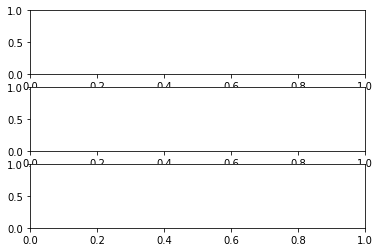

In [29]:
batch_size = 10

for i, (patch, size) in enumerate(ng):
    tf.logging.info("processing nodule {}".format(i))
    nodule = classifier({"patch": patch, "size": size})
    dets[det_field_name][i] = parse_result(dets[det_field_name][i], nodule)

IndexError: too many indices for array

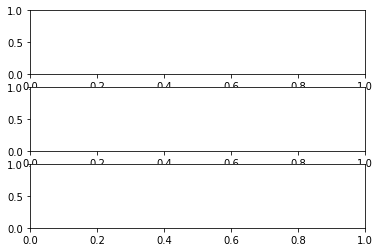

In [30]:
fig, axarr = plt.subplots(3)

axarr[0].imshow(f["data"].squeeze()[0, 16, :, :])
axarr[1].imshow(f["data"].squeeze()[0, :, 16, :])
im = axarr[2].imshow(f["data"].squeeze()[0, :, :, 16])
fig.colorbar(im)

In [21]:
f["data"].max()

819713.06

In [22]:
f["crop_data"].max()

686562.0

In [23]:
f["data"].mean(), f["crop_data"].mean()

(409856.53, 410995.28)

In [32]:
for i in range(0, 10, 4):
    print(i)

0
4
8


In [59]:
from itertools import chain, islice

def gen():
    for i in range(10):
        yield i
        
        
def chunks(iterable, size=10):
    iterator = iter(iterable)
    for first in iterator:
        yield chain([first], islice(iterator, size - 1))
        
nodule_idx = 0
for chunk in chunks(gen(), 7):
    next_batch = np.stack(list(chunk), axis=0)
    nodules = ...
    for nodule in nodules:
        dets[nodule_idx]...
        nodule_idx += 1

array([7, 8, 9])

In [58]:
for chunk in chunks(gen(), 7):
    next_batch = 

7
3


In [52]:
next(chunk)

1

In [50]:
for n, chunk in enumerate(chunks(els, 2)):
    for el in chunk:
        print 'Chunk %3d, value %d' % (n, el)

SyntaxError: invalid syntax (<ipython-input-50-a3569abea873>, line 3)